In [1]:
import pybullet_envs
import gym
import pygame
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
from ddpg import DDPG
from replay_buffer import ReplayBuffer
from utils import plot_learning_curve

In [2]:
env = gym.make('InvertedPendulumBulletEnv-v0')
print(env.action_space, env.observation_space.shape)
env.reset()

Box(-1.0, 1.0, (1,), float32) (5,)
argv[0]=


pybullet build time: Nov 28 2023 23:48:36


array([ 0.        ,  0.        ,  0.9978573 , -0.06542784,  0.        ])

argv[0]=


In [3]:
best_score = env.reward_range[0]
score_history = []

In [4]:
n_episodes = 250
max_size = 10_000
batch_size = 128
learning_freq = 40

In [5]:
ddpg = DDPG(env.observation_space.shape[0], action_dim=env.action_space.shape[0], 
           hidden_size=64, l2_reg=0.0, tau=.5, sigma=0.01)
replay_buffer = ReplayBuffer(max_size)

In [6]:
from time import sleep

def play_and_record(env, agent, buffer):
    state = env.reset()
    done = False
    score = 0
    state = torch.tensor(state, dtype=torch.float)
    while not done:
        # if np.random.rand() < .2:
        #     action = torch.tensor(env.action_space.sample())
        # else:
        action = agent.choose_action(state, train=True)
        # print(action)
        next_state, reward, done, _ = env.step(action)
        score += reward
        state = torch.tensor(state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        
        buffer.add(state, action, reward, next_state, done)
        # print(state, action, reward, next_state, done)
        # sleep(10)
        if len(buffer) > batch_size:
            batch = replay_buffer.sample(batch_size)
            agent.learning_step(batch)
            
        state = next_state
    
    return score

iteration 90 score 128.000 avg_score 54.022


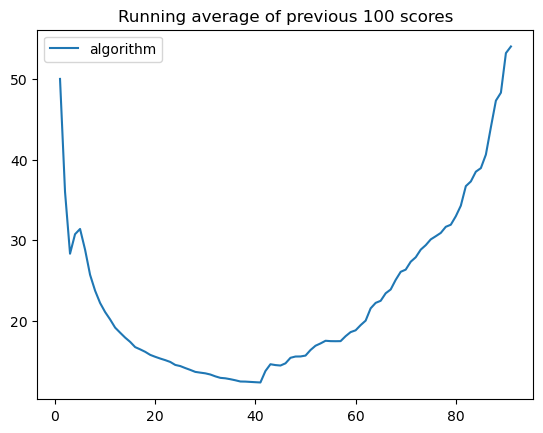

 37%|███▋      | 93/250 [00:37<01:02,  2.50it/s]


KeyboardInterrupt: 

In [7]:
avg_history = []
for i in tqdm(range(n_episodes)):
    score = play_and_record(env, ddpg, replay_buffer)
    ddpg.update_network_parameters()
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    avg_history.append(avg_score)
    if avg_score > best_score:
        best_score = avg_score
    if i % 10 == 0 and i > 0:
        plot_learning_curve(avg_history) 
        print(f"iteration {i} score {score:.3f} avg_score {avg_score:.3f}")
        plt.show()

    if avg_score > 900:
        break


In [ ]:
ddpg.critic

CriticNetwork(
  (model): MLPLayer(
    (model): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)